<a href="https://colab.research.google.com/github/rakibulhaque9954/sec-21-Shanghaitech_dataset/blob/main/sec_21_Shanghaitech_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [22]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
import scipy.io
import os
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.initializers import RandomNormal

# Dataset Download Kaggle

In [9]:

!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d tthien/shanghaitech-with-people-density-map


mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 4.78G/4.79G [04:39<00:00, 20.1MB/s]
100% 4.79G/4.79G [04:39<00:00, 18.4MB/s]


In [ ]:
!unzip '/content/shanghaitech-with-people-density-map.zip' -d '/content/dataset'

# Gaussian Maps Conversion Function

In [12]:
IN_X, IN_Y = 768, 1024 # height and width
OUT_X, OUT_Y = 96, 128 # desired height and width
SUBSAMPLING_FACTOR = IN_X//OUT_X # downsampling in the vertical direction(height)
# 768 // 96 = 8 so that means the output will only be combined for every 8 pixels in the input image, this is to reduce the resolution
BATCH_SIZE =

In [13]:
def gauss_distribution(x, u = 0, sigma = 2):
  return np.expand_dims((1/(np.sqrt(2 * np.pi *(sigma ** 2)))) * np.exp(-(0.5) * (((x - u)/ sigma)** 2)), axis = 0)
  # this formula follows standard Gaussian distribution's probability density function, normalizing it so that the area under the bell curve always remains 1

In [14]:
def get_density_map_gaussian(im, points, gaussian_radius = 2):
  # gaussian_radius is basically increasing the area of the gaussian box(heads) to make it bigger or smaller or adaptive
  # its a hyperparameter
  # points are the positions where each head is located

  density_map = np.zeros((OUT_X, OUT_Y))

  w, h = OUT_Y, OUT_X

  num_gt = len(points)

  for point in points:

    point = np.round(point).astype(int)
    point[0], point[1] = min(h-1, point[1]), min(w-1, point[0]) # calculating the x, y coordinates of the point
    # incase the point falls in exactly h and w then we take one point before that

    x = np.linspace(-gaussian_radius, gaussian_radius, (gaussian_radius * 2) + 1)

    gaussian_map = np.multiply(gauss_distribution(x), gauss_distribution(x).T)
    gaussian_map /= np.sum(gaussian_map) # sometimes the gaussian map values dont sum upto 1, then we normalize to add up to 1

    x_left, x_right, y_up, y_down = 0, gaussian_map.shape[1], 0, gaussian_map.shape[0]

    if point[1] < gaussian_radius:
      x_left = gaussian_radius - point[1]
      # print('x-l',x_left)

    if point[0] < gaussian_radius:
      y_up = gaussian_radius - point[0]
      # print('y-up',y_up)

    if point[1] + gaussian_radius >= w:
      x_right = gaussian_map.shape[1] - (gaussian_radius + point[1] - w) -1
      # print('x-r', x_right)

    if point[0] + gaussian_radius >= h:
      y_down = gaussian_map.shape[0] - (gaussian_radius + point[0] - h) - 1
      # print('y-down', y_down)
    # this part is mostly so that the values are all fitted inside the width and the height of the image
    # it readjusts the pointer and brings it back in line, mostly with edge values


    density_map[
        max(0, point[0] - gaussian_radius): min(density_map.shape[0], point[0] + gaussian_radius + 1),
        max(0, point[1] - gaussian_radius): min(density_map.shape[1], point[1] + gaussian_radius + 1)
    ] += gaussian_map[y_up: y_down, x_left: x_right]
    # this part determines the location of the point of the object
    # determining the width and height coordinates of the density map, the max plots the starting point of the w/h line while min plots the end
    # Then the positon is just added to the gaussian map

  density_map /= np.sum(density_map / len(points)) # re-normalizes to fit the maps values in the map
  return density_map

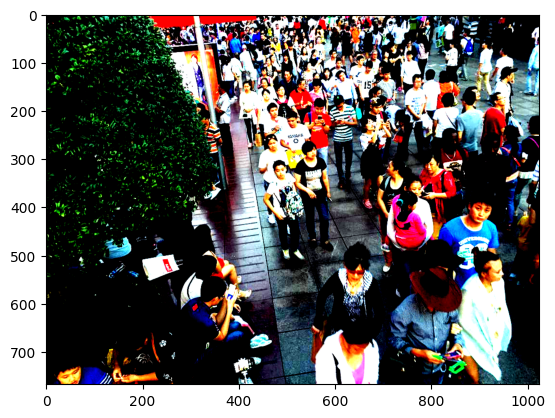

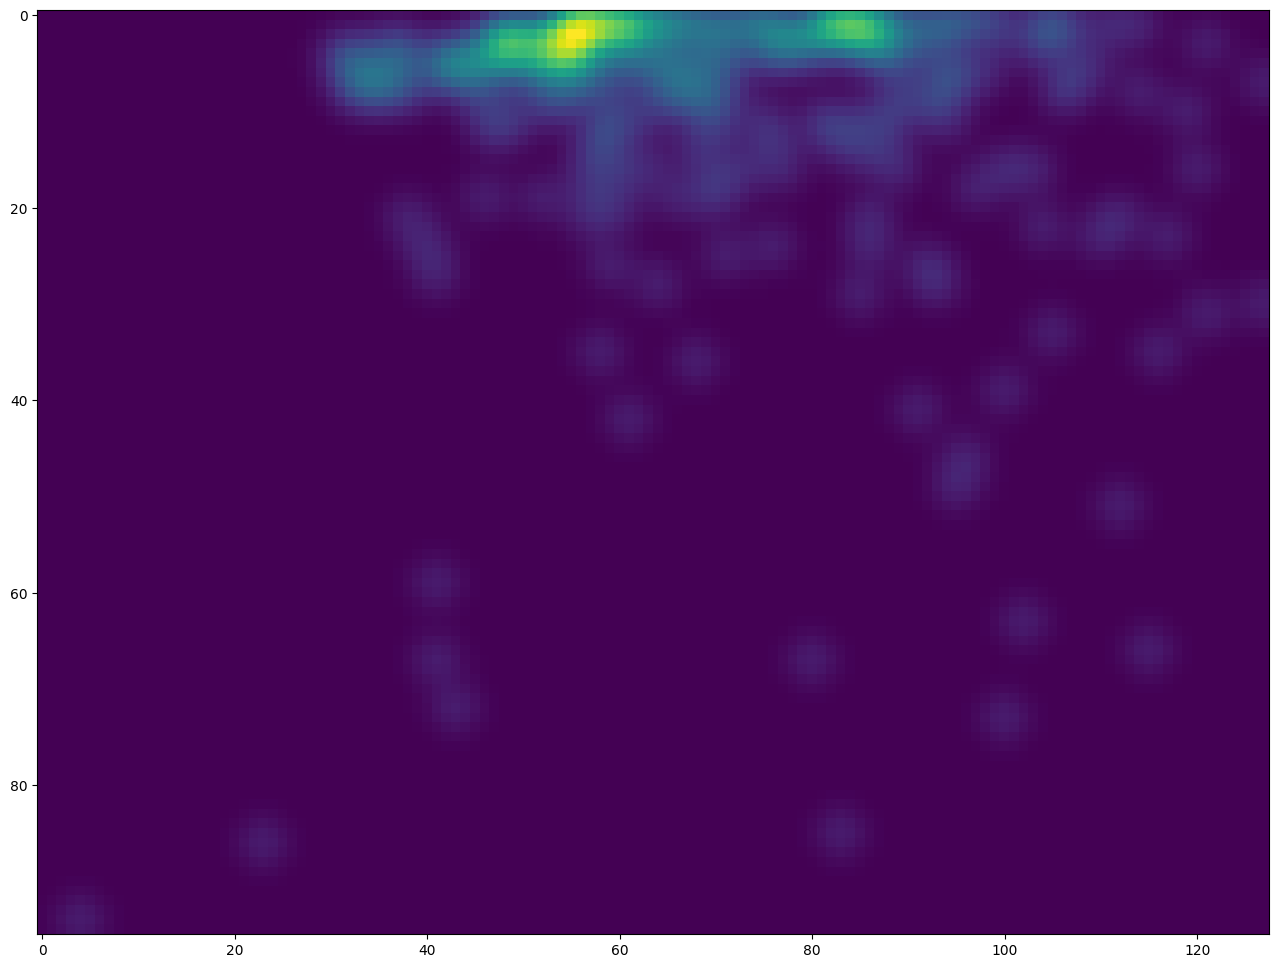

In [15]:
train_images = '/content/dataset/ShanghaiTech/part_B/train_data/images/'
train_maps = '/content/dataset/ShanghaiTech/part_B/train_data/ground-truth/'

IN = 'IMG_1'
im_array = img_to_array(load_img(train_images + IN + '.jpg', target_size = (IN_X, IN_Y)))


im_array /= 255
im_array[: , :, 0] = (im_array[:, :, 0] - np.mean(im_array[:, :, 0])) / np.std(im_array[:, :, 0])
im_array[: , :, 1] = (im_array[:, :, 1] - np.mean(im_array[:, :, 1])) / np.std(im_array[:, :, 1])
im_array[: , :, 2] = (im_array[:, :, 2] - np.mean(im_array[:, :, 2])) / np.std(im_array[:, :, 2])
# normalizing the image/ standardization(z-score normalization)
# converting pixel values between 0 and 1, and converting channel values(im_array[:, :, channel]) to value between 0 and 1


X = im_array
plt.imshow(X)

mat = scipy.io.loadmat(train_maps + 'GT_' + IN + '.mat')
points = mat['image_info'][0][0][0][0][0]
# print(points)

points /= SUBSAMPLING_FACTOR
# print(points)

y = get_density_map_gaussian(X, points, gaussian_radius=10,)

plt.figure(figsize=(20, 12))
plt.imshow(y)
plt.show()

More smaller the standard deviation(Sigma) the more condensed the mean becomes apparent which makes the heads more dense, even the Gaussian Radius plays a big role in density, if the radius is bigger more the area thus making the head look more spread out and less dense.

# Gaussian Distribution Explanation

In [16]:
print(gauss_distribution(np.linspace(-40, 40, 40*2 + 1), sigma = 2)) # linspace just iterates from 1 point to another and produces the amount of values you want
#(1st num, 2nd num, no. of points) default is 50 points

[[2.76047418e-88 5.36588917e-84 8.12318018e-80 9.57716246e-76
  8.79374771e-72 6.28836191e-68 3.50209107e-64 1.51895085e-60
  5.13081536e-57 1.34975651e-53 2.76535477e-50 4.41237749e-47
  5.48303280e-44 5.30634407e-41 3.99941388e-38 2.34759768e-35
  1.07319187e-32 3.82082771e-30 1.05940963e-27 2.28768780e-25
  3.84729931e-23 5.03896770e-21 5.13988679e-19 4.08311782e-17
  2.52613554e-15 1.21716027e-13 4.56736020e-12 1.33477831e-10
  3.03794142e-09 5.38488002e-08 7.43359757e-07 7.99187055e-06
  6.69151129e-05 4.36341348e-04 2.21592421e-03 8.76415025e-03
  2.69954833e-02 6.47587978e-02 1.20985362e-01 1.76032663e-01
  1.99471140e-01 1.76032663e-01 1.20985362e-01 6.47587978e-02
  2.69954833e-02 8.76415025e-03 2.21592421e-03 4.36341348e-04
  6.69151129e-05 7.99187055e-06 7.43359757e-07 5.38488002e-08
  3.03794142e-09 1.33477831e-10 4.56736020e-12 1.21716027e-13
  2.52613554e-15 4.08311782e-17 5.13988679e-19 5.03896770e-21
  3.84729931e-23 2.28768780e-25 1.05940963e-27 3.82082771e-30
  1.0731

As we move towards the centre the values increase look at the e-01 value which is the largest, and as we move further out the values decrease but all of these add up to 1, which is the gaussian head value. The graph formed is the the bell curve where the mean lies in the centre.

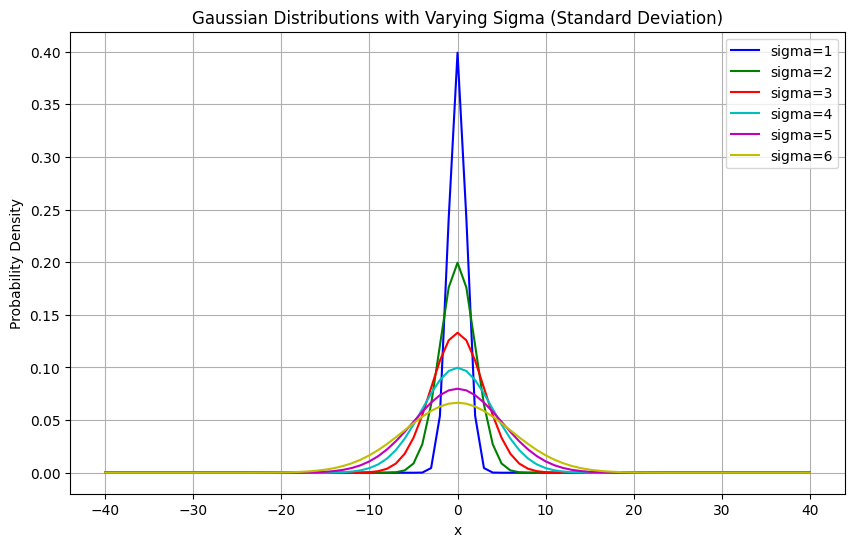

In [17]:
# plotting the bell graph for reference
def gauss_distribution_ref(x, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x / sigma) ** 2))
x = np.linspace(-40, 40, 40*2 + 1)
sigmas = [1, 2, 3, 4, 5, 6]  # Range of sigma values
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Colors for the lines

plt.figure(figsize=(10, 6))

for sigma, color in zip(sigmas, colors):
    y = gauss_distribution_ref(x, sigma)
    plt.plot(x, y, label=f'sigma={sigma}', color=color)

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gaussian Distributions with Varying Sigma (Standard Deviation)')
plt.grid(True)
plt.legend()
plt.show()

As you increase the standard deviation (sigma), the area under the curve (which represents the total probability) remains the same, but the distribution becomes wider, and more points are considered within the curve. This means that the probability becomes more spread out, and more values are included within a certain range of the distribution as sigma increases.

So, to summarize:

Increasing sigma makes the distribution wider.
The area under the curve (total probability) remains the same.
More values are included within the curve as sigma increases, meaning a larger range of values is considered within the distribution.

The graph above shows that, with varying sigmas come varying curves with varying areas and points.

The one that will be used will be a 3 dimensional Gaussian map with height and width. Shown below:

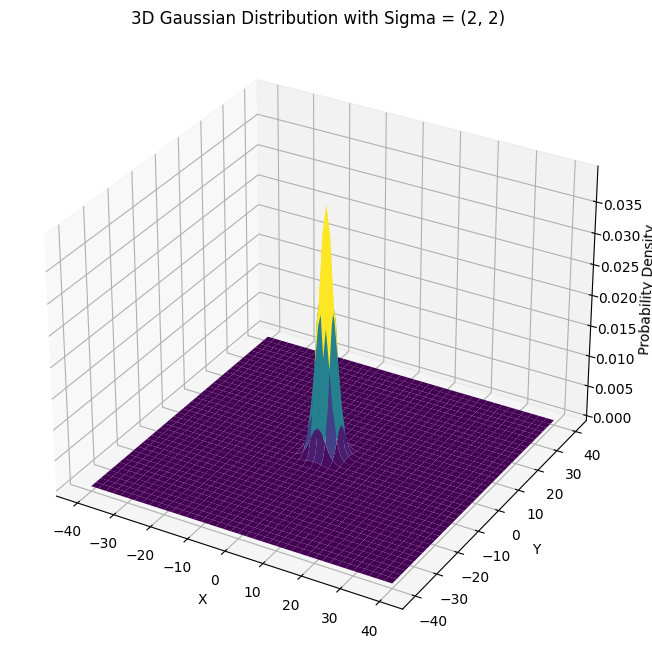

In [18]:
from mpl_toolkits.mplot3d import Axes3D

def gauss_distribution_3d(x, y, sigma):
    return (1 / (2 * np.pi * sigma[0] * sigma[1])) * np.exp(
        -0.5 * ((x / sigma[0]) ** 2 + (y / sigma[1]) ** 2))

x = np.linspace(-40, 40, 40 * 2 + 1)
y = np.linspace(-40, 40, 40 * 2 + 1)
X, Y = np.meshgrid(x, y)
sigma = (2, 2)  # Sigma value for the Gaussian distribution, sigma value of x-axis controls the width  of the distribution, along the x-axis
# and for the y-axis sigma values control the width along the y-axis
# The height is calculated by the gaussian function

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

Z = gauss_distribution_3d(X, Y, sigma)
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Probability Density')
ax.set_title(f'3D Gaussian Distribution with Sigma = {sigma}')
plt.show()

Smaller the sigma, more localized and concentrated the data point.

# Data generator

In [60]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__ (self, images, maps, batch_size, SUBSAMPLING_FACTOR=8):

        self.images = images
        self.maps = maps
        self.batch_size = batch_size
        self.train_image_list = os.listdir(images)
        self.SUBSAMPLING_FACTOR=SUBSAMPLING_FACTOR

    def __len__(self):
        return int(np.floor(len(self.train_image_list)/self.batch_size))

    def __getitem__(self, idx):
        x,y = self.__data_generation(idx)
        return x,y

    def __data_generation(self, idx):
        x = []
        y = []

        for j in range(idx*self.batch_size, (idx+1)*self.batch_size):

            im_array = img_to_array(load_img(self.images+os.listdir(self.images)[j],target_size=(IN_X,IN_Y)))
            im_array /= 255. # normalization

            im_array[:,:,0]=(im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
            im_array[:,:,1]=(im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
            im_array[:,:,2]=(im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])
            # normalization for channels
            x.append(im_array)

            mat = scipy.io.loadmat(self.maps+os.listdir(self.maps)[j])
            # loading mat format
            points = mat['image_info'][0][0][0][0][0]
            points /= self.SUBSAMPLING_FACTOR

            density_map_present = get_density_map_gaussian(im_array,points, gaussian_radius= 5) # radius set to 5
            y.append(density_map_present)
        return tf.convert_to_tensor(x),tf.convert_to_tensor(y)

Same thing done as before just this time the images and the obtained gaussian values are converted to tensors for training, validation and testing.

## Data Variables

In [63]:
train_images = '/content/dataset/ShanghaiTech/part_B/train_data/images/'
train_maps = '/content/dataset/ShanghaiTech/part_B/train_data/ground-truth/'

BATCH_SIZE = 1
LR = 1e-5
EPOCH = 20

In [64]:
train_gen = DataGenerator(train_images, train_maps, BATCH_SIZE, SUBSAMPLING_FACTOR)

#Modelling

## CSRNet(Convolutional Sparse Regression Network)

Dialated CNN for the highly congested scenes.<br>
paper link: https://arxiv.org/pdf/1802.10062.pdf <br>
- Contains a CNN as the front end for 2D feature extraction,
- A backend of a dialated CNN which uses dialated kernels to deliver larger reception fields and to replace larger pooling operations.
- Technique used by CSRNet is sparse regerssion where it figures out how many objects are in the image, its does this by learning from the data provided.

Sparse Regression:
In sparse regression, important features are assigned non-zero coefficients, while less important features receive coefficients close to zero. Feature scaling and regularization techniques like L1 regularization (Lasso) encourage certain features to become sparse (coefficients set to zero) while emphasizing the importance of others.sparse regression is a more general statistical technique used for various purposes, including feature selection and regression tasks in different domains.

Benefits of Sparse Regression:
- Feature Interpretability: Sparse regression helps identify the most important features, making it easier to interpret the model's results.
- Dimensionality Reduction: It reduces the dimensionality of the problem, which can lead to simpler and more efficient models.
- Noise Reduction: By removing less relevant features, sparse regression can help reduce the influence of noisy or irrelevant data.

### Front end (Normal CNN)

In [52]:
# using VGG16 as the base model(transfer learning) as the front end (CNN)
def get_base_model():

  base_model = tf.keras.applications.VGG16(weights='imagenet', input_shape=(IN_X, IN_Y, 3), include_top=False) # top layers are fully connected layers where classification is done mostly aka output
  # since we just want the feature extarctor we will exclude top

  block4_conv3 = [base_model.get_layer(layer_name).output for layer_name in ["block4_conv3"]] # removing this layer block since the paper leaves it out

  return Model(
        inputs = base_model.inputs ,outputs = block4_conv3
    )


get_base_model().summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 768, 1024, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 768, 1024, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 768, 1024, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 384, 512, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 384, 512, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 384, 512, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 192, 256, 128)     0  

### Backend(Dialated CNN)

In [53]:
inputs = tf.keras.Input(shape = (IN_X, IN_Y, 3))
x = get_base_model()(inputs)
init = RandomNormal(0.01)

print(x)


x = Conv2D(512, (3,3), activation = 'relu', dilation_rate = 2, kernel_initializer = init, padding = 'same')(x)
x = Conv2D(512, (3,3), activation = 'relu', dilation_rate = 2, kernel_initializer = init, padding = 'same')(x)
x = Conv2D(512, (3,3), activation = 'relu', dilation_rate = 2, kernel_initializer = init, padding = 'same')(x)
x = Conv2D(256, (3,3), activation = 'relu', dilation_rate = 2, kernel_initializer = init, padding = 'same')(x)
x = Conv2D(128, (3,3), activation = 'relu', dilation_rate = 2, kernel_initializer = init ,padding = 'same')(x)
x = Conv2D(64, (3,3), activation = 'relu', dilation_rate = 2, kernel_initializer = init, padding = 'same')(x)
x = Conv2D(1, (1,1), activation = 'relu', dilation_rate = 1, kernel_initializer = init, padding = 'same')(x)

output = Reshape((96,128))(x)
model = tf.keras.Model(inputs = inputs, outputs= output)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 96, 128, 512), dtype=tf.float32, name=None), name='model_21/block4_conv3/Relu:0', description="created by layer 'model_21'")
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 768, 1024, 3)]    0         
                                                                 
 model_21 (Functional)       (None, 96, 128, 512)      7635264   
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_11 (Conv2D)          (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_12 (Conv2D)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


# Training

## Loss Function

Euclidean loss, also known as L2 loss or Mean Squared Error (MSE) loss, is a common loss function used in various machine learning and deep learning tasks, particularly in regression problems. It quantifies the dissimilarity between predicted values and actual (target) values by calculating the squared differences between corresponding elements.

Key points about Euclidean loss:

- It penalizes larger errors more severely because it squares the differences. This means that outliers or large errors have a significant impact on the loss.
- It is sensitive to the scale of the data, so it's important to preprocess data and outputs appropriately.
- It is commonly used in regression problems, where the goal is to predict continuous numeric values, such as predicting house prices, stock prices, or temperature.

The objective is to minimize the Euclidean's Distance loss

In [54]:
def custom_loss(y_true, y_pred):
  return tf.sqrt(tf.math.reduce_sum(tf.square(y_true - y_pred)))

Custom Loss = sqrt(Σ(y_true - y_pred)^2)


### Difference between Mean Averaged Error and Mean Squared Error(Type of Euclidean's Loss)

 Mean Absolute Error (MAE) does not penalize large errors as severely as Euclidean Loss (Mean Squared Error or MSE) does. In MAE, the errors are measured by taking the absolute value of the differences between predicted values and actual values and then averaging those absolute differences.

Because MAE uses the absolute differences, it treats all errors equally regardless of their size. This means that large errors and small errors contribute equally to the overall loss. As a result, MAE is less sensitive to outliers and is often preferred in situations where you want to avoid the influence of extreme values.

On the other hand, MSE squares the errors before averaging them. This means that larger errors have a disproportionately greater impact on the loss compared to smaller errors. As a result, MSE tends to penalize larger errors more severely and can be sensitive to outliers.

The choice between MAE and MSE depends on the characteristics of your data and the specific goals of your machine learning model. If you want your model to be robust to outliers and you don't want large errors to dominate the loss, MAE may be a better choice. However, if you want to emphasize reducing large errors and are willing to tolerate some sensitivity to outliers, MSE might be more appropriate.

MSE formula:
MSE = (1/n) * Σ(y_true - y_pred)^2


## Compilation and Fitting

In [65]:
model.compile(
    loss = custom_loss,
    optimizer = Adam(learning_rate = LR),
    metrics = 'mae' # mean average error
)


## Callbacks

In [66]:
checkpoint_filepath = 'people_counting/CSRnet.hdf5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

In [67]:
history = model.fit(train_gen, verbose = 1, shuffle = True, epochs = EPOCH, callbacks = [callback])

Epoch 1/20
400/400 [==============================] - 540s 1s/step - loss: 1785344768.0000 - accuracy: 0.0074
Epoch 2/20
400/400 [==============================] - 502s 1s/step - loss: 5041789.0000 - accuracy: 0.0413
Epoch 3/20
400/400 [==============================] - 481s 1s/step - loss: 1834980.6250 - accuracy: 0.1104
Epoch 4/20
125/400 [========>.....................] - ETA: 7:06 - loss: 903508.5625 - accuracy: 0.1405

KeyboardInterrupt: ignored

Accuracy is not very meaningful in regression

# Testing

In [68]:
model.load_weights('people_counting/CSRnet.hdf5')

1/1 [==============================] - 0s 48ms/step
The actual number of people is= 152
The predicted number of people is = 10048551.0


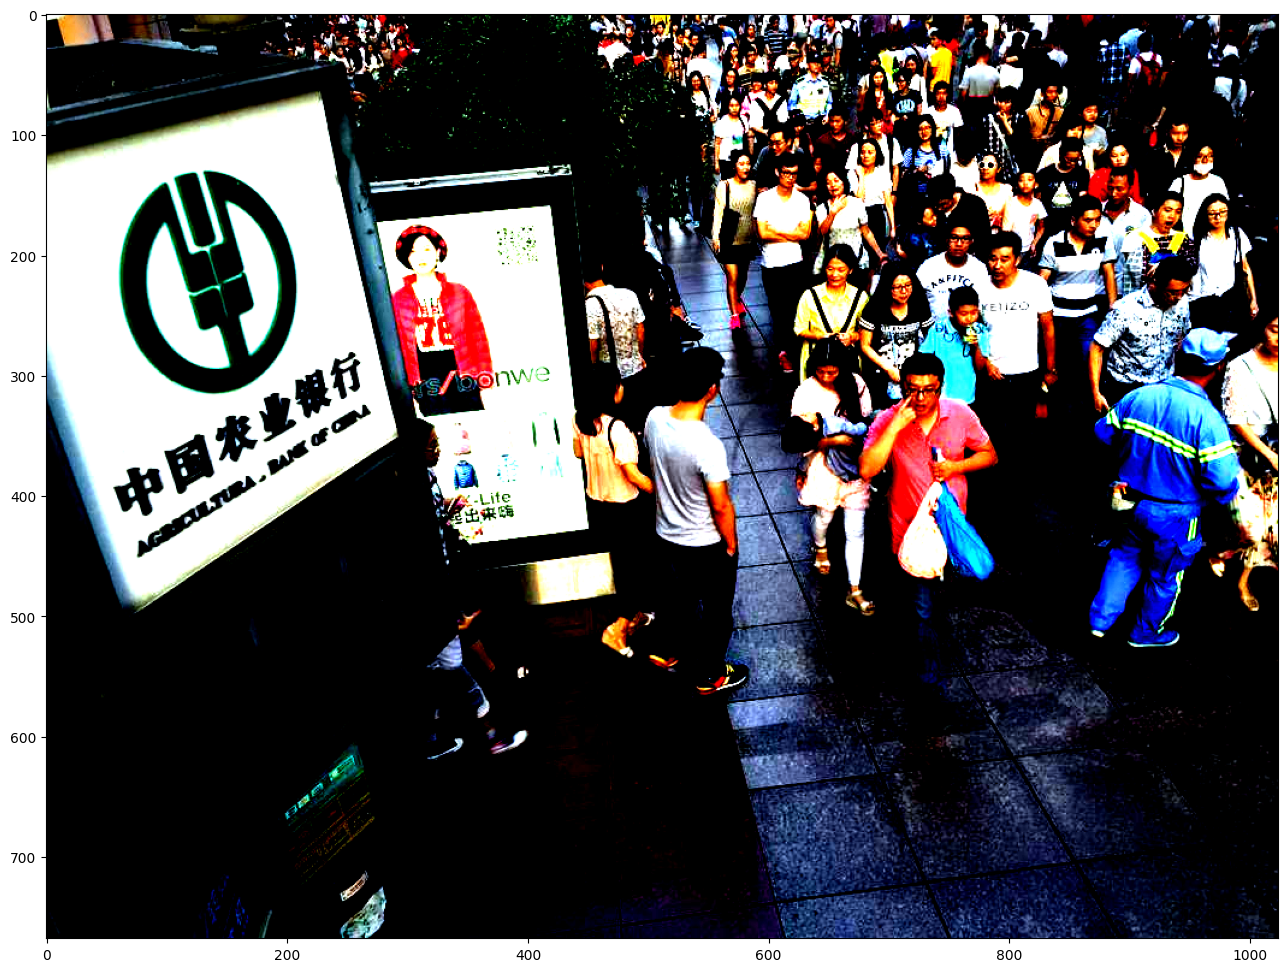

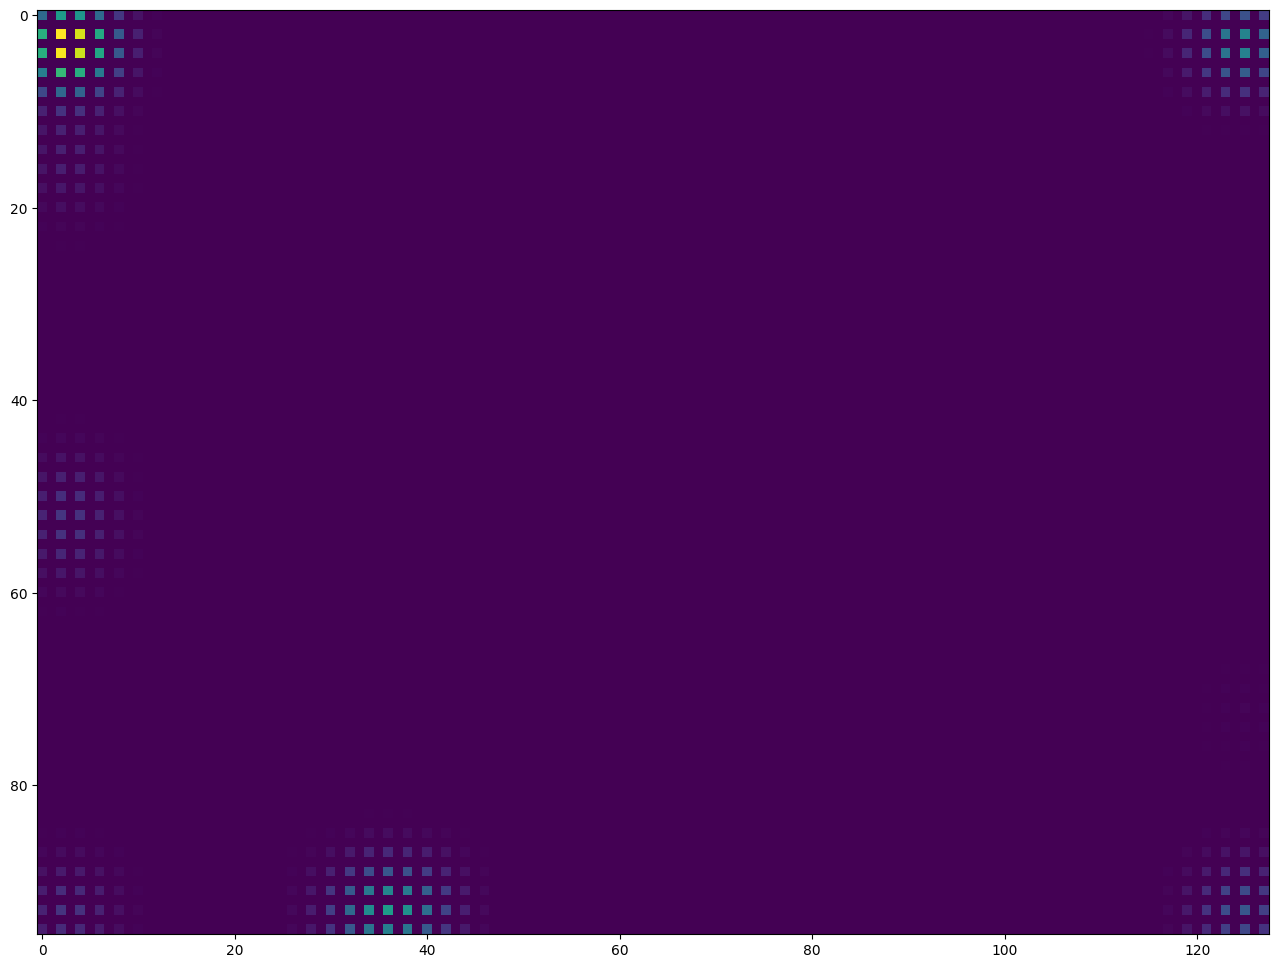

In [71]:
IN ='IMG_2'

im_array=img_to_array(load_img(train_images + IN + '.jpg',target_size=(IN_X,IN_Y)))
im_array/=255.
im_array[:,:,0] = (im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
im_array[:,:,1] = (im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
im_array[:,:,2] = (im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])

plt.figure(figsize=(20,12))
plt.imshow(im_array)

output= model.predict(tf.expand_dims(im_array,axis=0))
output= np.reshape(output,(OUT_X,OUT_Y))

n_people = np.sum(output)
mat = scipy.io.loadmat(train_maps+ 'GT_' + IN + '.mat')
points = mat['image_info'][0][0][0][0][0]
points /= SUBSAMPLING_FACTOR

num_gt = np.squeeze(points).shape[0] # reducing dims
print("The actual number of people is =", num_gt)
print("The predicted number of people is =", n_people)

plt.figure(figsize=(20,12))
plt.imshow(output)